In [1]:
import pandas as pd
import numpy as np
import plotly.express as px

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import  Dense, Dropout
import keras_nlp

import tensorflow_text as text
import tensorflow_hub as hub

from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

/Users/mojc/code/essay_scoring/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/mojc/code/essay_scoring/venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data = pd.read_csv("learning-agency-lab-automated-essay-scoring-2/train.csv")

X_train, X_val, y_train, y_val = train_test_split(data['full_text'], data['score'], test_size=0.2, random_state=42)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape )

(13845,) (3462,) (13845,) (3462,)


In [3]:
# labels for classifications
y_train = (y_train - 1).to_numpy()
y_val = (y_val - 1).to_numpy()

In [16]:
class_weights = class_weight.compute_class_weight('balanced',
                                                  classes=np.unique(y_train),
                                                  y=y_train)
# Convert to a dictionary with class indices as keys
class_weight_dict = dict(enumerate(class_weights))
# Print the computed class weights (optional)
print(class_weight_dict)

{0: 2.326108870967742, 1: 0.6140234167110165, 2: 0.46011964107676967, 3: 0.7265428211586902, 4: 2.9320203303684877, 5: 19.72222222222222}


In [37]:
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string)
# does tokanization, padding and truncation
preprocessor = keras_nlp.models.BertPreprocessor.from_preset("bert_base_en", trainable=False)
encoder_inputs = preprocessor(text_input)
encoder = keras_nlp.models.BertBackbone.from_preset("bert_base_en", load_weights=True, trainable=False)
outputs = encoder(encoder_inputs)
pooled_output = outputs["pooled_output"]  # Shape: [batch_size, 768]

In [38]:
for layer in encoder.layers:
    layer.trainable = False

In [39]:
sequence_output = outputs["sequence_output"]  # [batch_size, seq_length, 768].

In [40]:
l = tf.keras.layers.Dense(128, activation='relu', name='h1')(pooled_output)
l = tf.keras.layers.Dense(64, activation='relu',name='h2')(l)
l = tf.keras.layers.Dense(32, activation='relu', name='h3')(l)
l = tf.keras.layers.Dense(16, activation='relu', name='h4')(l)
l = tf.keras.layers.Dense(6, activation='softmax', name='output')(l)

model=tf.keras.Model(inputs=[text_input], outputs=[l])
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4),
              loss='sparse_categorical_crossentropy', # from logits
              metrics=['accuracy'])
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bert_preprocessor_3 │ [(None, 512),     │          0 │ input_layer_3[0]… │
│ (BertPreprocessor)  │ (None, 512),      │            │                   │
│                     │ (None, 512)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bert_backbone       │ [(None, 768),     │ 108,310,2… │ bert_preprocesso… │
│ (BertBackbone)      │ (None, 512, 768)] │            │ bert_preprocesso… │
│                     │                   │            │ bert_preprocesso… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ h1 (Dense)          │ (None, 128)       │     98,432 │ bert_backbone[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ h2 (Dense)          │ (None, 64)        │      8,256 │ h1[0][0]          │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ h3 (Dense)          │ (None, 32)        │      2,080 │ h2[0][0]          │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ h4 (Dense)          │ (None, 16)        │        528 │ h3[0][0]          │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 6)         │        102 │ h4[0][0]          │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 108,419,670 (413.59 MB)

 Trainable params: 109,398 (427.34 KB)

 Non-trainable params: 108,310,272 (413.17 MB)

In [41]:
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=8, batch_size=32, validation_data=(X_val, y_val), callbacks=callback, class_weight=class_weight_dict)
model.evaluate(X_val, y_val)
# accuracy: 0.0777 - loss: 1.1673
# accuracy: 0.5426 - loss: 1.0492

Epoch 1/8
433/433 ━━━━━━━━━━━━━━━━━━━━ 1144s 3s/step - accuracy: 0.2199 - loss: 1.7825 - val_accuracy: 0.3758 - val_loss: 1.7287
Epoch 2/8
433/433 ━━━━━━━━━━━━━━━━━━━━ 1130s 3s/step - accuracy: 0.3252 - loss: 1.6936 - val_accuracy: 0.3180 - val_loss: 1.6946
Epoch 3/8
433/433 ━━━━━━━━━━━━━━━━━━━━ 1110s 3s/step - accuracy: 0.2877 - loss: 1.6020 - val_accuracy: 0.3238 - val_loss: 1.6383
Epoch 4/8
433/433 ━━━━━━━━━━━━━━━━━━━━ 1125s 3s/step - accuracy: 0.3301 - loss: 1.5587 - val_accuracy: 0.3348 - val_loss: 1.5455
Epoch 5/8
433/433 ━━━━━━━━━━━━━━━━━━━━ 1129s 3s/step - accuracy: 0.3181 - loss: 1.4705 - val_accuracy: 0.3325 - val_loss: 1.5116
Epoch 6/8
433/433 ━━━━━━━━━━━━━━━━━━━━ 1127s 3s/step - accuracy: 0.3272 - loss: 1.4315 - val_accuracy: 0.3784 - val_loss: 1.4662
Epoch 7/8
433/433 ━━━━━━━━━━━━━━━━━━━━ 1127s 3s/step - accuracy: 0.3423 - loss: 1.4146 - val_accuracy: 0.3111 - val_loss: 1.5437
Epoch 8/8
433/433 ━━━━━━━━━━━━━━━━━━━━ 1129s 3s/step - accuracy: 0.3404 - loss: 1.4247 - val_accu

[1.4460300207138062, 0.327556312084198]

In [42]:
preds_raw = model.predict(X_val) #[:, 0]

109/109 ━━━━━━━━━━━━━━━━━━━━ 204s 2s/step


In [43]:
preds_raw

array([[0.08796851, 0.06708861, 0.30545077, 0.2818798 , 0.14771019,
        0.10990208],
       [0.0200202 , 0.01894055, 0.08042336, 0.19509542, 0.35237208,
        0.33314836],
       [0.46467105, 0.4381181 , 0.05843787, 0.02048518, 0.00997801,
        0.00830984],
       ...,
       [0.11710854, 0.13502938, 0.42622232, 0.21968764, 0.0537574 ,
        0.04819467],
       [0.3788655 , 0.49073136, 0.10366504, 0.01853915, 0.0040348 ,
        0.00416415],
       [0.3499332 , 0.46724018, 0.142767  , 0.02760709, 0.00615985,
        0.00629269]], dtype=float32)

In [44]:
preds = preds_raw.argmax(axis=-1)

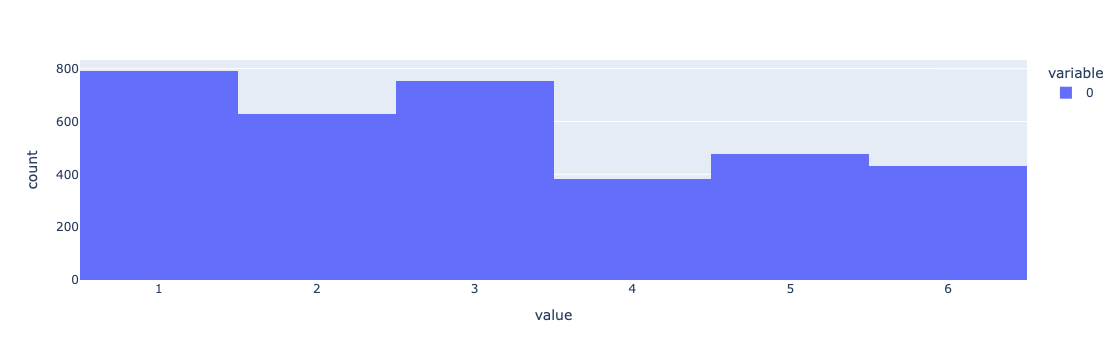

In [45]:
px.histogram(preds+1)

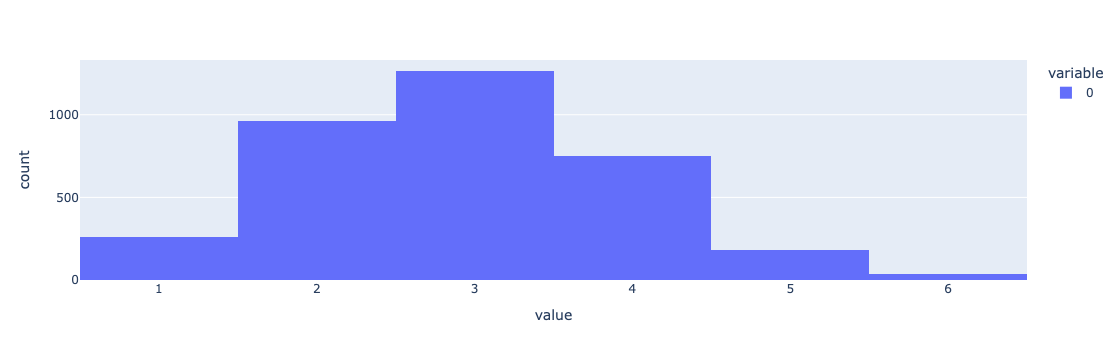

In [46]:
px.histogram(y_val+1)

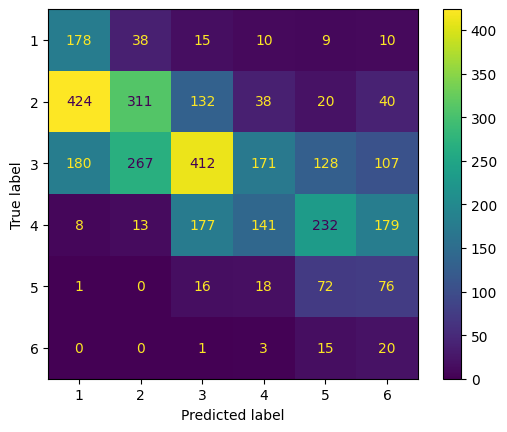

In [47]:
# Plot confusion matrix
cm = confusion_matrix(y_val+1, preds+1, labels=list(set(y_val+1)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(set(y_val+1)))
disp.plot()

In [ ]:
# comparison
# - LSTM
# val_accuracy: 0.3462
# - bert uncased
# val_accuracy: 0.5687
# - bert uncased w class weights
# val_accuracy: 0.4830
# - bert base (slow training, only predicting 2, 3, 4)
# val_accuracy: 0.5370
# - bert base w class weights 
# val_accuracy: 0.3276

In [15]:
print(np.mean(abs(preds - y_val)))
print(np.mean((np.round(preds, 0) - y_val)**2))

1.91231125951693
4.8272674754477185


In [16]:
print(min(preds), max(preds))

0.00030520812 0.9299879
